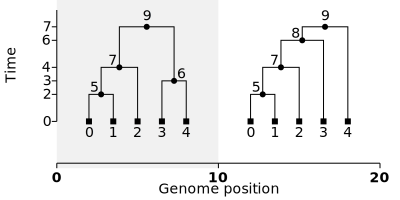

In [1]:
import io
import tskit

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
1         0
0         2
0         3
0         4
0         6
0         7
"""

edges = """\
left   right   parent  child
0      20      5       0,1
0      10      6       3,4
0      20      7       5,2
0      10      9       7,6
10     20      8       7,3
10     20      9       8,4
"""

# sites = """\
# position ancestral_state
# """

# mutations = """\
# site node parent derived_state
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    # sites=io.StringIO(sites),
    # mutations=io.StringIO(mutations),
    strict=False,
)

ts.draw_svg(y_axis=True)

In [48]:
list(ts.at(0).nodes())

[9, 6, 3, 4, 7, 2, 5, 0, 1]

In [51]:
list(ts.at_index(1).nodes())

[9, 4, 8, 3, 7, 2, 5, 0, 1]

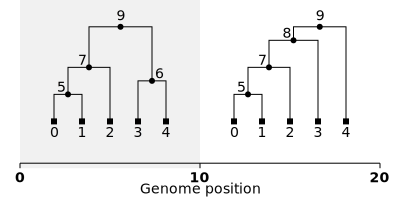

In [50]:
ts.draw_svg()

In [103]:
[ts.at_index(0).branch_length(u) for u in ts.at_index(0).nodes()]

[0, 4.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 2.0]

In [104]:
list(ts.at_index(0).nodes())

[9, 6, 3, 4, 7, 2, 5, 0, 1]

In [105]:
[ts.at_index(1).branch_length(u) for u in ts.at_index(1).nodes()]

[0, 7.0, 1.0, 6.0, 2.0, 4.0, 2.0, 2.0, 2.0]

In [106]:
list(ts.at_index(1).nodes())

[9, 4, 8, 3, 7, 2, 5, 0, 1]

In [113]:
[ts.at_index(0).branch_length(u) for u in range(ts.num_nodes)]

[2.0, 2.0, 4.0, 3.0, 3.0, 2.0, 4.0, 3.0, 0, 0]

In [112]:
[ts.at_index(1).branch_length(u) for u in range(ts.num_nodes)]

[2.0, 2.0, 4.0, 6.0, 7.0, 2.0, 0, 2.0, 1.0, 0]

In [57]:
ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]

array([2., 2., 3., 3., 4., 2., 6., 2., 7., 4., 3., 1.])

In [71]:
ts.edges_child

array([0, 1, 3, 4, 2, 5, 3, 7, 4, 6, 7, 8], dtype=int32)

In [87]:
ts.tables.nodes.flags

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=uint32)

In [89]:
ts.tables.nodes.flags ^ 1

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=uint32)

tree 0 ============================
[{0}, {1}, {2}, {3}, {4}, set(), set(), set(), set(), set()]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


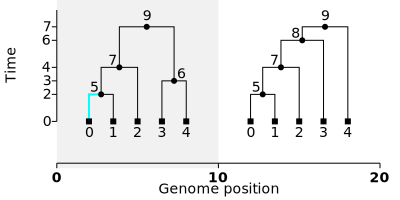

set() {0}


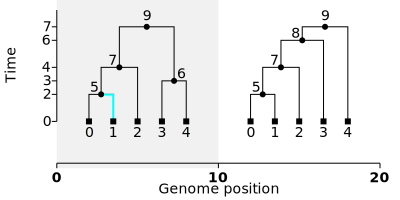

{0} {1}


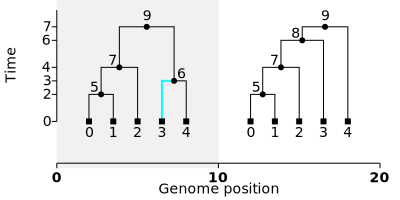

set() {3}


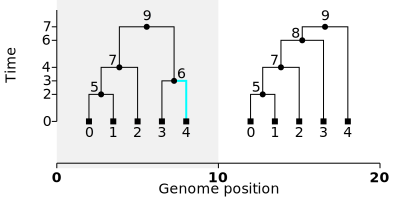

{3} {4}


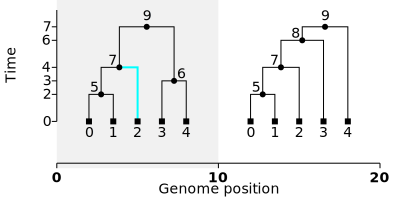

set() {2}


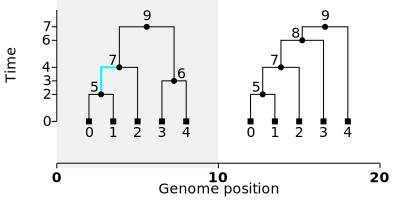

{2} {0, 1}


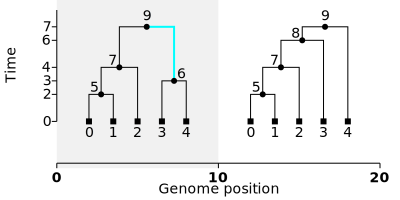

set() {3, 4}


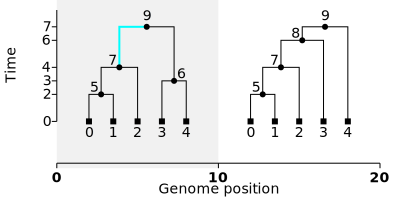

{3, 4} {0, 1, 2}
tree 1 ============================
[{0}, {1}, {2}, {3}, {4}, {0, 1}, {3, 4}, {0, 1, 2}, set(), {0, 1, 2, 3, 4}]
[0, 0, 0, 0, 0, 5.0, 4.0, 3.0, 0, 0.0]


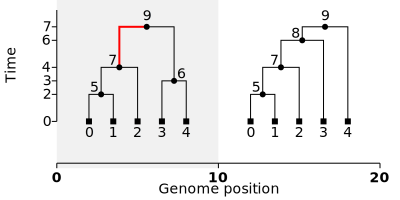

{0, 1, 2, 3, 4} {0, 1, 2}


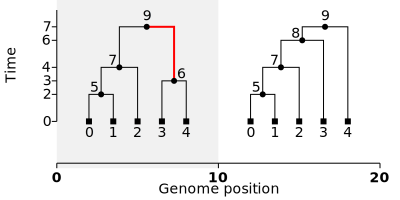

{3, 4} {3, 4}


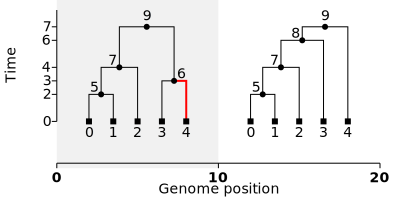

{3, 4} {4}


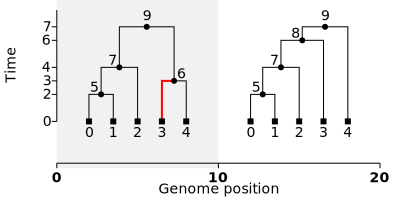

{3} {3}


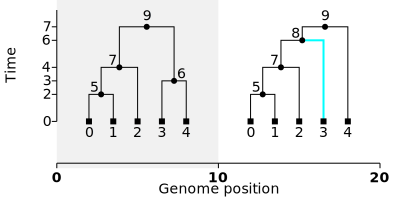

set() {3}


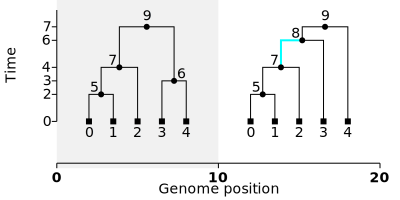

{3} {0, 1, 2}


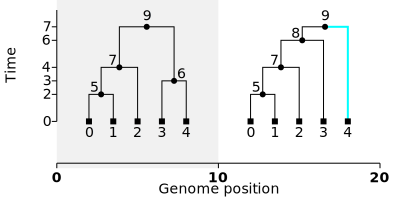

set() {4}


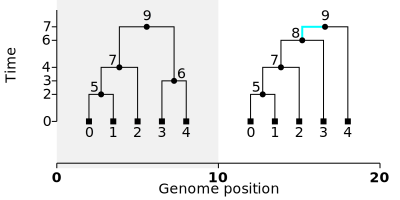

{4} {0, 1, 2, 3}


In [116]:
from IPython import display
samples_under_nodes = [set() for _ in range(ts.num_nodes)]
# cum_branch = [0 for _ in range(ts.num_nodes)]
parents = [tskit.NULL] * ts.num_nodes

time = ts.tables.nodes.time
# edge_lengths = [0 for _ in range(ts.num_edges)]
edge_lengths = [0 for _ in range(ts.num_nodes)]

for s in ts.samples():
    samples_under_nodes[s].add(s)

edges_out = ts.indexes_edge_removal_order
edges_in = ts.indexes_edge_insertion_order

tj, tk, t_left, tree_index = 0, 0, 0, 0

while tj < ts.num_edges or t_left < ts.sequence_length:
    print(f"tree {tree_index} ============================")
    # print(list(enumerate(cum_branch)))
    print(samples_under_nodes)
    print(edge_lengths)
    while tk < ts.num_edges and ts.edges_right[edges_out[tk]] == t_left:
        e = edges_out[tk]
        tk += 1
        child = ts.edges_child[e]
        parent = ts.edges_parent[e]
        display.display(ts.draw_svg(style=f'.t{tree_index - 1} .a{parent}.n{child} > .edge {{stroke: red; stroke-width: 2px}}', y_axis=True))
        print(samples_under_nodes[parent], samples_under_nodes[child])
        edge_lengths[parent] = 0

        while parent != tskit.NULL:
            # print('-', parent, time[parent], time[child], time[parent] - time[child])
            # cum_branch[parent] -= (time[parent] - time[child]) + cum_branch[child]
            samples_under_nodes[parent] -= samples_under_nodes[child]
            # print(samples_under_nodes[parent], samples_under_nodes[child], end='|')
            parent = parents[parent]
        # print()
        parents[child] = tskit.NULL

    while tj < ts.num_edges and ts.edges_left[edges_in[tj]] == t_left:
        e = edges_in[tj]
        tj += 1
        child = ts.edges_child[e]
        parent = ts.edges_parent[e]
        # branch_len += p_time[parent] - c_time[child]
        display.display(ts.draw_svg(style=f'.t{tree_index} .a{parent}.n{child} > .edge {{stroke: cyan; stroke-width: 2px}}', y_axis=True))
        print(samples_under_nodes[parent], samples_under_nodes[child])
        # edge_lengths[e] = (7 * (ts.tables.nodes.flags[child] ^ 1)) - time[child]
        edge_lengths[parent] = 7 - time[parent]

        parents[child] = parent
        while parent != tskit.NULL:
            # print('+', parent, time[parent], time[child], time[parent] - time[child])
            # cum_branch[parent] += (time[parent] - time[child]) + cum_branch[child]
            samples_under_nodes[parent] |= samples_under_nodes[child]
            # print(samples_under_nodes[parent], samples_under_nodes[child], end='|')
            parent = parents[parent]
        # print()

    t_right = ts.sequence_length
    if tj < ts.num_edges:
        t_right = min(t_right, ts.edges_left[edges_in[tj]])
    if tk < ts.num_edges:
        t_right = min(t_right, ts.edges_right[edges_out[tk]])

    # set the lefthand bound
    t_left = t_right
    tree_index += 1

In [117]:
edge_lengths

[0, 0, 0, 0, 0, 5.0, 0, 3.0, 1.0, 0.0]

In [36]:
samples_under_nodes

[{0},
 {1},
 {2},
 {3},
 {4},
 {0, 1},
 set(),
 {0, 1, 2},
 {0, 1, 2, 3},
 {0, 1, 2, 3, 4}]

In [35]:
list(enumerate(cum_branch))

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 4.0),
 (6, 0.0),
 (7, 10.0),
 (8, 18.0),
 (9, 26.0)]

In [3]:
from itertools import combinations, product
def combine(num_samples):
    """
    All sample pairings for 2/3/4 distinct samples.
    """
    ij = list(combinations(range(num_samples), 2))
    ijk = [(i, j, k) for i, j, k in product(range(num_samples), repeat=3)
           if i != k and i != j and j != k]
    ijkl = [(i, j, k, l) for i, j in combinations(range(num_samples), 2)
            for k in range(num_samples)
            for l in range(k + 1, num_samples)
            if i != k and j != k and l != i and l != j]
    return ij, ijk, ijkl

In [4]:
list(map(len, combine(5)))

[10, 60, 30]

In [5]:
def gen_ijk(i, j, n):
    for k in sorted(set(range(n)) - {i, j}):
        yield i, j, k
        yield j, i, k


def gen_ijkl(i, j, n):
    i, j = sorted([i, j])
    for k, l in combinations(sorted(set(range(n)) - {i, j}), 2):
        yield i, j, k, l

In [6]:
sorted(list(gen_ijk(0, 1, 5)))

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 0, 2), (1, 0, 3), (1, 0, 4)]

In [7]:
len(set([t for i, j in combinations(range(5), 2) for t in gen_ijk(i, j, 5)]))

60

In [8]:
len(set([t for i, j in combinations(range(5), 2) for t in gen_ijkl(i, j, 5)]))

30

In [9]:
len([t for i, j in combinations(range(5), 2) for t in gen_ijkl(i, j, 5)])

30

In [10]:
set(combine(5)[1]) ^ set([t for i, j in combinations(range(5), 2) for t in gen_ijk(i, j, 5)])

set()

In [11]:
set(combine(5)[2]) ^ set([t for i, j in combinations(range(5), 2) for t in gen_ijkl(i, j, 5)])

set()

In [12]:
sorted(list(gen_ijk(0, 1, 5)))

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 0, 2), (1, 0, 3), (1, 0, 4)]

In [13]:
sorted(list(gen_ijkl(0, 1, 5)))

[(0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4)]

In [15]:
sorted(list(gen_ijk(0, 3, 5)))

[(0, 3, 1), (0, 3, 2), (0, 3, 4), (3, 0, 1), (3, 0, 2), (3, 0, 4)]

In [17]:
combine(5)[2]

[(0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 3, 4),
 (0, 2, 1, 3),
 (0, 2, 1, 4),
 (0, 2, 3, 4),
 (0, 3, 1, 2),
 (0, 3, 1, 4),
 (0, 3, 2, 4),
 (0, 4, 1, 2),
 (0, 4, 1, 3),
 (0, 4, 2, 3),
 (1, 2, 0, 3),
 (1, 2, 0, 4),
 (1, 2, 3, 4),
 (1, 3, 0, 2),
 (1, 3, 0, 4),
 (1, 3, 2, 4),
 (1, 4, 0, 2),
 (1, 4, 0, 3),
 (1, 4, 2, 3),
 (2, 3, 0, 1),
 (2, 3, 0, 4),
 (2, 3, 1, 4),
 (2, 4, 0, 1),
 (2, 4, 0, 3),
 (2, 4, 1, 3),
 (3, 4, 0, 1),
 (3, 4, 0, 2),
 (3, 4, 1, 2)]

In [52]:
ts.at_index(0).total_branch_length

23.0

In [53]:
ts.at_index(1).total_branch_length

26.0